In [2]:
import os, glob, gc, regex as re, numpy as np, pandas as pd, simplification.cutil as simpl, \
    matplotlib.pyplot as plt, joblib as jl, json, time, matplotlib.gridspec as gridspec, \
    matplotlib.colors as mplcol, colorcet, miniball, matplotlib.ticker as ticker, itertools, \
    joblib as jl, colorcet
from tqdm import tqdm_notebook as tqdm

# Source: https://stackoverflow.com/questions/2158395/flatten-an-irregular-list-of-lists
flatten = lambda *n: (e for a in n
    for e in (flatten(*a) if isinstance(a, (tuple, list)) else (a,)))

os.getpid()

17916

### Plot recall/precision/F1 results

In [273]:
STAGES = ['protoweb+radii', 'protoweb', 'radii', 'spiral_aux', 'spiral_cap', 'stabilimentum']

In [364]:
modelRequiresAllStages = True
STAGES_PERF_EVAL = ['protoweb+radii', 'spiral_aux', 'spiral_cap', 'stabilimentum']
STAGES_PERF_EVAL_3 = ['protoweb+radii', 'spiral_aux', 'spiral_cap']

In [ ]:
dataAll = {}
for numRegimes in [5,4,3]: 
    dataAll[numRegimes] = []
    
    res = pd.concat([pd.read_pickle(x) for x in tqdm(glob.glob(
        'Z:/Abel/data-tmp/F1_v2_{}_*.pickle'.format(numRegimes)))]).reset_index()

    if modelRequiresAllStages:
        res.loc[:,'allstages'] = [len(set(list(
            y for y in x if y != ',')))==5 for x in tqdm(res.mapping, leave=False)]
        res = res[res.allstages]
    
    # Get "best" models
    f1 = res[(res.numregimes==numRegimes)].groupby([
        'recid', 'stage', 'mapping']).agg({'f1S': np.nanmax, 'recallS': np.nanmax}).reset_index()
    bestModels = res[res.stage.isin(STAGES_PERF_EVAL if numRegimes > 3 else STAGES_PERF_EVAL_3)].copy()
    bestModels.recall.fillna(value=0.0, inplace=True)
    bestModels.precision.fillna(value=0.0, inplace=True)
    bestModels.f1S.fillna(value=0.0, inplace=True)
    bestModels = bestModels.groupby(['recid', 'mapping', 'rep']).agg({
        'precisionS': 'min', 'recallS': 'min', 'f1S': 'min'}).reset_index()
    bestModels = bestModels.groupby(['mapping', 'rep']).agg({
        'precisionS': 'median', 'recallS': 'median', 'f1S': 'median'}).reset_index()
    bestCandIdx = bestModels.index[bestModels.groupby(['rep',]).f1S.idxmax()]
    bestCandIdx = bestModels.loc[bestCandIdx,:].copy().reset_index().sort_values(
        by='f1S', ascending=False)[:5].loc[:,'index'].values
    
    for istage in range(len(STAGES)):
        for icandIdx, candIdx in enumerate(bestCandIdx):
            yvals = res.f1S[(res.stage==STAGES[istage])&(res.rep==bestModels.rep[candIdx])&(
                res.mapping==bestModels.mapping[candIdx])].values
            xvals = istage + (np.random.random(size=yvals.size) - 0.5) * 0.5
            dataAll[numRegimes].append((istage, icandIdx, candIdx, xvals, yvals, bestModels.rep[candIdx]))

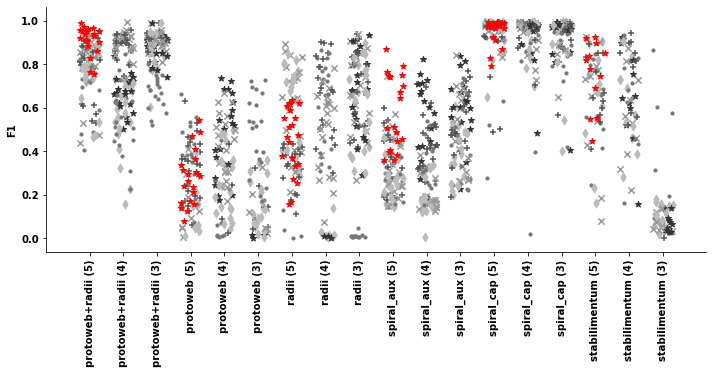

In [413]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(10,5.3))

MARKERS = ['*', '+', '.', 'x', 'd']

for regimeOffset in range(3):
    for istage, icandIdx, candIdx, xvals, yvals, rep in dataAll[3 + regimeOffset]:
        xvals = istage * 3 + (2-regimeOffset) + (np.random.random(size=yvals.size) - 0.5) * 0.6
        col = plt.get_cmap('gray')(0.2 + 0.8 * (icandIdx/len(STAGES)))
        if regimeOffset == 2:
            if rep == 9:
                col = 'red'
        #elif regimeOffset == 1:
        #    if rep == 44:
        #        col = 'red'
        for x, y in zip(xvals, yvals):
            ax.scatter(x, y, color=col, 
                zorder=100 if col=='red' else np.random.randint(0, 99),
                marker=MARKERS[icandIdx], s=40, clip_on=False) # 9, 14

xticks = list(range(18))
xticklabels = ['{} ({})'.format(x, nr) for x in STAGES for nr in [5, 4, 3]]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=90)

[ax.spines[x].set_visible(False) for x in ['top', 'right']]

ax.set_ylabel('F1')
fig.tight_layout()
fig.savefig('C:/Users/acorver/Desktop/paper-figures/Fig_F1_543.pdf')